In [1]:
import matplotlib.pyplot as plt
import ipywidgets
from ipywidgets import interact
import numpy as np
import subprocess
import os
import scipy.io as sio
import pandas as pd
from functools import reduce
from itertools import product
from joblib import Parallel, delayed

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

import sys
if '..' not in sys.path: # My notebooks are usually one directory in.
    sys.path.append('..')
    
from HVFF.HVFF import HVFF
from common.import_data import import_data, gen_interact_plot
from common.import_data import gen_setting
from common.metrics import f1_score, evalgroup

dataset_folder = os.environ["CV_dataset_folder"]
img_folder = os.environ["CV_relazione_img_folder"]
random_state = 42

example_name = "Synth/"
f'{dataset_folder}  {img_folder}'

'/home/lucavecchi/uni/visione_artificiale/data/  /home/lucavecchi/uni/visione_artificiale/relazione/img/'

In [8]:
features,groundtruth,settings,settings_gc = import_data(dataset_folder + example_name)
features.head(10),groundtruth.head(10),settings,settings_gc

(   frame  id           x           y     angle
 0      0   1  260.000000  200.000000  0.000000
 1      0   2  280.000000  240.000000  4.712389
 2      0   3  200.000000  320.000000  4.188790
 3      0   4  200.000000  200.000000  2.094395
 4      0   5  140.000000  280.000000  5.497787
 5      0   6   60.000000  280.000000  1.570796
 6      0   7  380.000000  140.000000  0.785398
 7      0   8  120.000000   80.000000  4.712389
 8      1   1  259.631623  200.252545  0.000000
 9      1   2  279.881167  240.124320  4.712389,    frame               groups
 0      0  [[1, 2], [3, 4, 5]]
 1      1  [[1, 2], [3, 4, 5]]
 2      2  [[1, 2], [3, 4, 5]]
 3      3  [[1, 2], [3, 4, 5]]
 4      4  [[1, 2], [3, 4, 5]]
 5      5  [[1, 2], [3, 4, 5]]
 6      6  [[1, 2], [3, 4, 5]]
 7      7  [[1, 2], [3, 4, 5]]
 8      8  [[1, 2], [3, 4, 5]]
 9      9  [[1, 2], [3, 4, 5]], {'radius': 30.0,
  'covmat': array([[4.5e+02, 0.0e+00, 0.0e+00],
         [0.0e+00, 4.5e+02, 0.0e+00],
         [0.0e+00, 0.0e+00,

In [3]:
frames = features['frame'].unique()
frames

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
group_frame = frames//10
group_frame

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9])

In [11]:
settings['covmat']= settings['covmat']/2
settings['radius']= 30

In [12]:
intr_thr = 0.001
tolerance = 2/3

In [13]:
for intr_thr in [0.0001,0.0005,0.0008,0.001,0.2,0.7]:
    frame_id = 1
    r = []
    for frame_id in range(0,100,2):
        frame = features[features['frame']==frame_id]
        gt = groundtruth[groundtruth['frame'] == frame_id].iloc[0]
        gt_group = gt['groups']


        hvff = HVFF(settings,random_state)
        res  = hvff.identify_o_space(subjects=frame, intrusion_thr=intr_thr)                
        centers, weights, partecipants = zip(*res)
        part_2_or_more = [p for p in partecipants if len(p)>=2]
        prec,rec,tp,fp,fn = evalgroup(part_2_or_more,gt=gt_group,th=tolerance)


        centers = [(c,settings['radius']) for c,w,p in res if len(p) >= 2]
        r.append(([prec,rec,tp,fp,fn] ,res,gt_group))
    prec_tot = np.mean([ el[0][0] for el in r])
    rec_tot = np.mean([ el[0][1] for el in r])
    print(f'inthr_thr: {intr_thr}, prec_tot: {prec_tot}, rec_tot: {rec_tot}')

inthr_thr: 0.0001, prec_tot: 0.9166666666666665, rec_tot: 0.6666666666666665
inthr_thr: 0.0005, prec_tot: 0.9166666666666665, rec_tot: 0.6666666666666665
inthr_thr: 0.0008, prec_tot: 0.9166666666666665, rec_tot: 0.6666666666666665
inthr_thr: 0.001, prec_tot: 0.9166666666666665, rec_tot: 0.6666666666666665
inthr_thr: 0.2, prec_tot: 0.9166666666666665, rec_tot: 0.6666666666666665
inthr_thr: 0.7, prec_tot: 0.9166666666666665, rec_tot: 0.6666666666666665


In [8]:
xlim = (features['x'].min(),features['x'].max())
ylim = (features['y'].min(),features['y'].max())
gen_interact_plot(features,xlim,ylim,circles=centers)

interactive(children=(IntSlider(value=0, description='nth_frame', max=99), Output()), _dom_classes=('widget-in…

<function common.import_data.gen_interact_plot.<locals>.plot_arrows_frame(nth_frame=IntSlider(value=0, description='nth_frame', max=99))>

In [98]:
division = 2
rang_mult = 5
sett = settings['covmat']
empty = settings['empty']
nsample = settings['nsamples']
quant = settings['quant']
radius = settings['radius']
grid = {'sigma': np.arange(sett[0][0]/rang_mult,sett[0][0]*rang_mult,(sett[0][0]*rang_mult - sett[0][0]/rang_mult)/division  ),
       'sd_alpha': np.arange(sett[2][2]/rang_mult,sett[2][2]*rang_mult,(sett[2][2]*rang_mult - sett[2][2]/rang_mult)/division  ),
        'quant': [5,10],#np.arange(quant/rang_mult,quant*2,(quant*2 - quant/rang_mult)/division ),
        'empty': [0.3,0.7],#np.arange(0.1,0.9,0.3),
        'nsamples': [800],#np.arange(400,1001,(1001-400)/division),
        'radius' : np.arange(10,70,20),
        'intrusion_thr': np.arange(0.1,0.8,0.25)
       }
tot_el= len(list(product(*grid.values())))
tot_el, grid

(144,
 {'sigma': array([ 18., 234.]),
  'sd_alpha': array([4.0e-05, 5.2e-04]),
  'quant': [5, 10],
  'empty': [0.3, 0.7],
  'nsamples': [800],
  'radius': array([10, 30, 50]),
  'intrusion_thr': array([0.1 , 0.35, 0.6 ])})

Essendo che l'algoritmo è definito dai parametri fissati a priori e non appreso dai dati, che calcolare la performance sul validation set per ogni inner-fold e poi effettuare una media equivale a effettuare su tutto il train-val il calcolo della performance ci porta a ignorare il fold interno.

In [ ]:
n_splits = 3

X = frames
y = group_frame

sss_outer = StratifiedShuffleSplit(n_splits=n_splits,test_size=0.3,random_state=random_state) # sss_inner = StratifiedShuffleSplit(n_splits=n_splits,test_size=0.3,random_state=random_state)

def eval_f1_score_on_hvff(center,gt,tolerance):
    centers, weights, partecipants = zip(*center)
    part_2_or_more = [p for p in partecipants if len(p)>=2]
    prec,rec,tp,fp,fn = evalgroup(part_2_or_more,gt=gt,th=tolerance)
    f1 = f1_score(prec,rec)
    return f1

results = []
for nth, (val_index, test_index)  in enumerate(sss_outer.split(X,y)):
    inner_frame = X[val_index]
    outer_frame = X[test_index]
    inner_df = features[features['frame'].isin(inner_frame)]
    outer_df = features[features['frame'].isin(outer_frame)]
    
    score = []
    for nth_param, others  in enumerate(product(*grid.values()) ):        
        
        sig,sd_alpha,q,em,nsam,rad,intr_thr = others
        settings = gen_setting(rad,sig,sig,sd_alpha,em,nsam,q,0)
        hvff = HVFF(settings=settings, random_state=random_state, debug=False)
        
        def parse_frame(frame_id):#,features,groundtruth):
            frame = features[features['frame']==frame_id]
            gt = groundtruth[groundtruth['frame'] == frame_id].iloc[0]
            gt_group = gt['groups']
            res  = hvff.identify_o_space(subjects=frame, intrusion_thr=intr_thr)                
            return eval_f1_score_on_hvff(res,gt_group,tolerance)
        
        score_inner = Parallel(n_jobs=4,verbose=10)(delayed(parse_frame)(f) for f in inner_frame)
        score.append( np.mean(score_inner) )
        
    #best param 
    index = np.argmax(score)
    best_settings = next(x for i,x in enumerate(product(*grid.values())) if i==index)
    best_score = score[index]
    
    print(f'{nth}° fold, score: {best_score} params: {best_settings}')
    results.append((index, best_score, best_settings))

print(f'Unbiased f1-score:{np.mean([ el[1] for el in results])}')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    6.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   12.3s
[Parallel(n_jobs=4)]: Done  70 out of  70 | elapsed:   15.4s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    7.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elap

Text(0.5, 1.0, 'Simulation of sampling o-space')

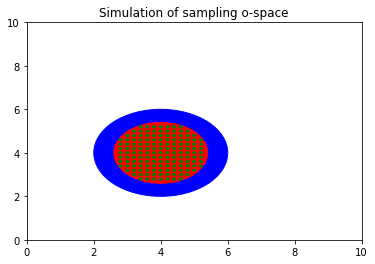

In [16]:
radius =2
intrusion=0.7
x=y=4
m,M = 0,10
resolution = 0.2
circle1 = plt.Circle((x, y), radius, color='r')


fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot

valid_pos = np.array(list( (_x,_y) for _x in np.arange(x-radius*intrusion,x+radius*intrusion,resolution) for _y in np.arange(y-radius*intrusion,y+radius*intrusion,resolution) if (x-_x)**2 + (y-_y)**2 < (radius*intrusion)**2  ))

circle = plt.Circle((x,y), radius, color='blue')
circle1 = plt.Circle((x,y), radius*intrusion, color='red')
plt.xlim([0,10])
plt.ylim([0,10])
ax.add_artist(circle)
ax.add_artist(circle1)
[ ax.add_artist(plt.Circle((a,b), 0.05,color='green')) for a,b in  valid_pos ]
plt.title("Simulation of sampling o-space")